In [659]:
#In this notebook we will run the experiments with the pytorch-forecasting library

import os
import warnings

warnings.filterwarnings("ignore")

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
import torch

import pytorch_forecasting
from pytorch_forecasting import Baseline, DeepAR, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import MAE, SMAPE, MultivariateNormalDistributionLoss, NormalDistributionLoss

from importlib import reload
import deepAR
reload(deepAR)
from deepAR import GASDeepAR, NormalDistributionLoss_GAS

DeepAR = GASDeepAR


In [660]:
data = generate_ar_data(seasonality=20.0, timesteps=4000, n_series=1, seed=42)
data["date"] = pd.Timestamp("2020-01-01") + pd.to_timedelta(data.time_idx, "D")


In [661]:
data = data.astype(dict(series=str))

# create dataset and dataloaders
max_encoder_length = 100
max_prediction_length = 50

training_cutoff = data["time_idx"].max() - max_prediction_length

context_length = max_encoder_length
prediction_length = max_prediction_length

data.head()

,series,time_idx,value,date
0,0,0,0.000000,2020-01-01
1,0,1,0.030814,2020-01-02
2,0,2,0.073035,2020-01-03
3,0,3,0.101790,2020-01-04
4,0,4,0.119993,2020-01-05


alpha_mu:  0.9999338930386481 alpha_sigma:  0.9999338930386481 beta_mu:  0.9993386729320827 beta_sigma:  0.12217202365588586 omega_mu:  0.0009329327941828034 omega_sigma:  0.4267984451029402 nu:  99.99996300097133


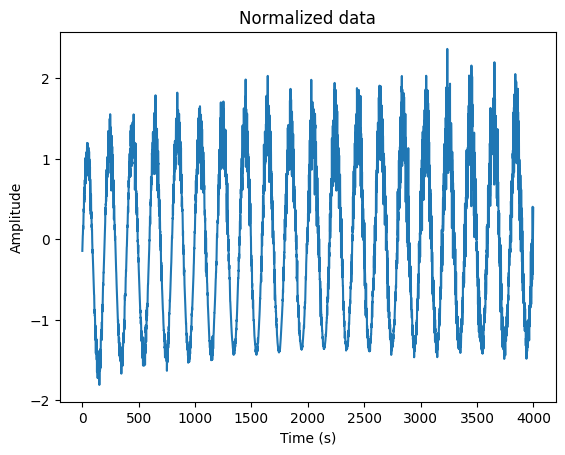

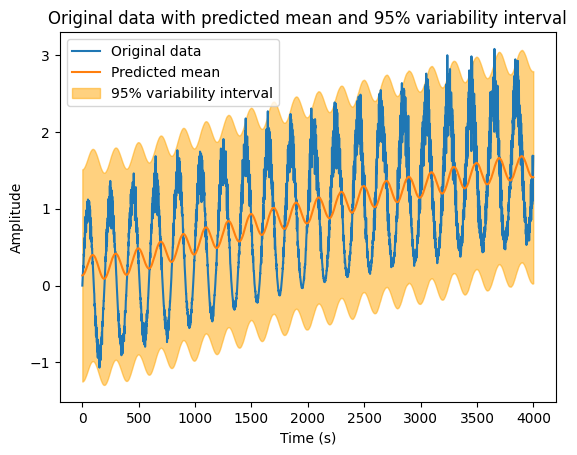

In [662]:
import GAS_norm
reload(GAS_norm)
from GAS_norm import SD_Normalization_Gaussian 
from GAS_norm import SD_Normalization_Student
import numpy as np

#Set the normalization strngth for the mean and the variance from 0 to 1
mean_norm_strength = 0.01
var_norm_strength = 0

norm_strength = [mean_norm_strength*0.5, var_norm_strength*0.5]


#mu_list, sigma2_list, y_norm, alpha_mu, alpha_sigma, beta_mu, beta_sigma, omega_mu, omega_sigma, nu = SD_Normalization_Student(data['value'], data['value'],  mode='predict', norm_strength=norm_strength)

gas_params = alpha_mu, alpha_sigma, beta_mu, beta_sigma, omega_mu, omega_sigma, nu, norm_strength

#print all gas parameters in one line
print('alpha_mu: ', alpha_mu, 'alpha_sigma: ', alpha_sigma, 'beta_mu: ', beta_mu, 'beta_sigma: ', beta_sigma, 'omega_mu: ', omega_mu, 'omega_sigma: ', omega_sigma, 'nu: ', nu)


#Plot the normalized data

plt.plot(data['time_idx'][1:], y_norm[1:])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Normalized data')
plt.show()

#Plot the original data with the predicted mean and 95% variability interval

plt.plot(data['time_idx'], data['value'], label='Original data')
plt.plot(data['time_idx'], mu_list, label='Predicted mean')
plt.fill_between(data['time_idx'], mu_list-1.96*np.sqrt(sigma2_list), mu_list+1.96*np.sqrt(sigma2_list), alpha=0.5, label='95% variability interval', color='orange')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Original data with predicted mean and 95% variability interval')
plt.legend()







In [663]:
#Add mean and variance to the dataframe

data['mu'] = mu_list
data['sigma2'] = sigma2_list

data.head()

,series,time_idx,value,date,mu,sigma2
0,0,0,0.000000,2020-01-01,0.132114,0.496007
1,0,1,0.030814,2020-01-02,0.132451,0.496107
2,0,2,0.073035,2020-01-03,0.132998,0.496119
3,0,3,0.101790,2020-01-04,0.133687,0.496120
4,0,4,0.119993,2020-01-05,0.134462,0.496121


In [664]:
training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="value",
    categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},
    group_ids=["series"],
    static_categoricals=[
        "series"
    ],  # as we plan to forecast correlations, it is important to use series characteristics (e.g. a series identifier)
    time_varying_unknown_reals=["value"],
    time_varying_known_reals=['mu', 'sigma2'],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
    target_normalizer= None,
    scalers={'mu': None, 'sigma2': None}
)

validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1)
batch_size = 128
# synchronize samples in each batch over time - only necessary for DeepVAR, not for DeepAR
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size, num_workers=0
)

In [666]:
pl.seed_everything(42)
import pytorch_forecasting as ptf

trainer = pl.Trainer(accelerator="cpu", gradient_clip_val=1e-1)
net = DeepAR.from_dataset(
    training,
    learning_rate=3e-2,
    hidden_size=30,
    rnn_layers=2,
    loss=NormalDistributionLoss_GAS(),
    optimizer="Adam",
    gas_params= gas_params
)

Seed set to 42
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Finding best initial lr:   1%|          | 1/100 [00:03<04:59,  3.03s/it]
`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 4 steps due to diverging loss.
Failed to compute suggestion for learning rate because there are not enough points. Increase the loop iteration limits or the size of your dataset/dataloader.
Restoring states from the checkpoint path at c:\Users\euret\OneDrive\Documenti\PhD\Experiments\Adaptive_Norm\.lr_find_4dc29b4f-b99e-4b94-95ec-8a0824ab4589.ckpt
Restored all states from the checkpoint at c:\Users\euret\OneDrive\Documenti\PhD\Experiments\Adaptive_Norm\.lr_find_4dc29b4f-b99e-4b94-95ec-8a0824ab4589.ckpt
Failed to compute suggestion for learning rate because there are not enough points. Increase the loop iteration limits or the size of your dataset/dataloader.
Failed to compute suggestion for learning rate because there are not enough points. Increase the loop iteration limits or the size of your dataset/dataloader.


suggested learning rate: None


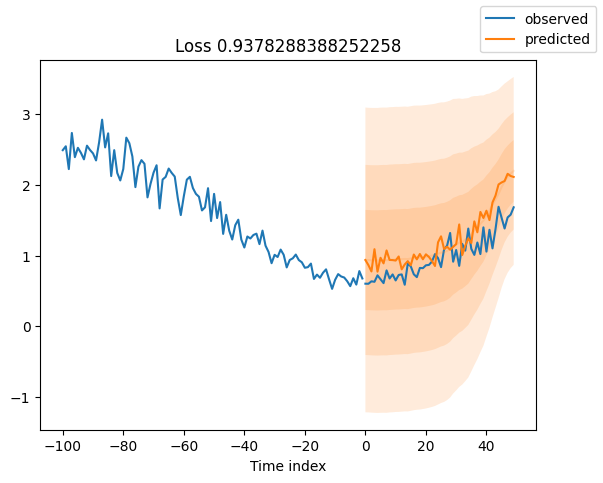

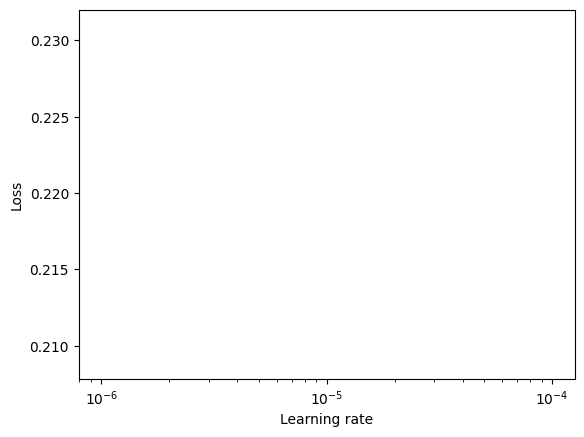

In [665]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    min_lr=1e-5,
    max_lr=1e0,
    early_stop_threshold=100,
)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()




In [672]:
net = DeepAR.from_dataset(
    training,
    learning_rate=3e-2,
    log_interval=10,
    log_val_interval=1,
    hidden_size=30,
    rnn_layers=2,
    loss=NormalDistributionLoss_GAS(),
    optimizer="Adam",
    gas_params= gas_params
)



early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=1,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
    limit_train_batches=50,
    enable_checkpointing=True,
)


trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                   | Type                       | Params
----------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss_GAS | 0     
1 | logging_metrics        | ModuleList                 | 0     
2 | embeddings             | MultiEmbedding             | 1     
3 | rnn                    | LSTM                       | 11.8 K
4 | distribution_projector | Linear                     | 62    
5 | AR_GAS                 | AR_GAS                     | 0     
----------------------------------------------------------------------
11.8 K    Trainable params
0         Non-trainable params
11.8 K    Total params
0.047     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 29/29 [01:12<00:00,  0.40it/s, v_num=166, train_loss_step=-.358, val_loss=-.278, train_loss_epoch=0.233]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 29/29 [01:12<00:00,  0.40it/s, v_num=166, train_loss_step=-.358, val_loss=-.278, train_loss_epoch=0.233]


In [673]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = DeepAR.load_from_checkpoint(best_model_path)

In [674]:
# best_model = net
predictions = best_model.predict(val_dataloader, trainer_kwargs=dict(accelerator="cpu"), return_y=True)
MAE()(predictions.output, predictions.y)



GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


torch.Size([100, 1, 4])
torch.Size([100, 1, 1])
torch.Size([100, 1, 4])
torch.Size([100, 1, 1])
torch.Size([100, 1, 4])
torch.Size([100, 1, 1])
torch.Size([100, 1, 4])
torch.Size([100, 1, 1])
torch.Size([100, 1, 4])
torch.Size([100, 1, 1])
torch.Size([100, 1, 4])
torch.Size([100, 1, 1])
torch.Size([100, 1, 4])
torch.Size([100, 1, 1])
torch.Size([100, 1, 4])
torch.Size([100, 1, 1])
torch.Size([100, 1, 4])
torch.Size([100, 1, 1])
torch.Size([100, 1, 4])
torch.Size([100, 1, 1])
torch.Size([100, 1, 4])
torch.Size([100, 1, 1])
torch.Size([100, 1, 4])
torch.Size([100, 1, 1])
torch.Size([100, 1, 4])
torch.Size([100, 1, 1])
torch.Size([100, 1, 4])
torch.Size([100, 1, 1])
torch.Size([100, 1, 4])
torch.Size([100, 1, 1])
torch.Size([100, 1, 4])
torch.Size([100, 1, 1])
torch.Size([100, 1, 4])
torch.Size([100, 1, 1])
torch.Size([100, 1, 4])
torch.Size([100, 1, 1])
torch.Size([100, 1, 4])
torch.Size([100, 1, 1])
torch.Size([100, 1, 4])
torch.Size([100, 1, 1])
torch.Size([100, 1, 4])
torch.Size([100,

tensor(0.6494)

In [675]:
raw_predictions = net.predict(
    val_dataloader, mode="raw", return_x=True, return_index=True, n_samples=100, trainer_kwargs=dict(accelerator="cpu")
)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


torch.Size([100, 1, 4])
torch.Size([100, 1, 1])
torch.Size([100, 1, 4])
torch.Size([100, 1, 1])
torch.Size([100, 1, 4])
torch.Size([100, 1, 1])
torch.Size([100, 1, 4])
torch.Size([100, 1, 1])
torch.Size([100, 1, 4])
torch.Size([100, 1, 1])
torch.Size([100, 1, 4])
torch.Size([100, 1, 1])
torch.Size([100, 1, 4])
torch.Size([100, 1, 1])
torch.Size([100, 1, 4])
torch.Size([100, 1, 1])
torch.Size([100, 1, 4])
torch.Size([100, 1, 1])
torch.Size([100, 1, 4])
torch.Size([100, 1, 1])
torch.Size([100, 1, 4])
torch.Size([100, 1, 1])
torch.Size([100, 1, 4])
torch.Size([100, 1, 1])
torch.Size([100, 1, 4])
torch.Size([100, 1, 1])
torch.Size([100, 1, 4])
torch.Size([100, 1, 1])
torch.Size([100, 1, 4])
torch.Size([100, 1, 1])
torch.Size([100, 1, 4])
torch.Size([100, 1, 1])
torch.Size([100, 1, 4])
torch.Size([100, 1, 1])
torch.Size([100, 1, 4])
torch.Size([100, 1, 1])
torch.Size([100, 1, 4])
torch.Size([100, 1, 1])
torch.Size([100, 1, 4])
torch.Size([100, 1, 1])
torch.Size([100, 1, 4])
torch.Size([100,

In [676]:
raw_predictions

Prediction(output=Output(prediction=tensor([[[0.3659, 0.3833, 0.4069,  ..., 0.3567, 0.6232, 0.3452],
         [0.4759, 0.5453, 0.5277,  ..., 0.5553, 0.1644, 0.5783],
         [0.3953, 0.3693, 0.3499,  ..., 0.6144, 0.5161, 0.4133],
         ...,
         [0.3796, 0.1914, 0.3090,  ..., 0.3589, 0.1630, 0.1797],
         [0.0920, 0.3100, 0.1505,  ..., 0.3341, 0.5302, 0.3240],
         [0.1781, 0.3355, 0.2265,  ..., 0.2643, 0.4974, 0.2461]]])), x={'encoder_cat': tensor([[[0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
      

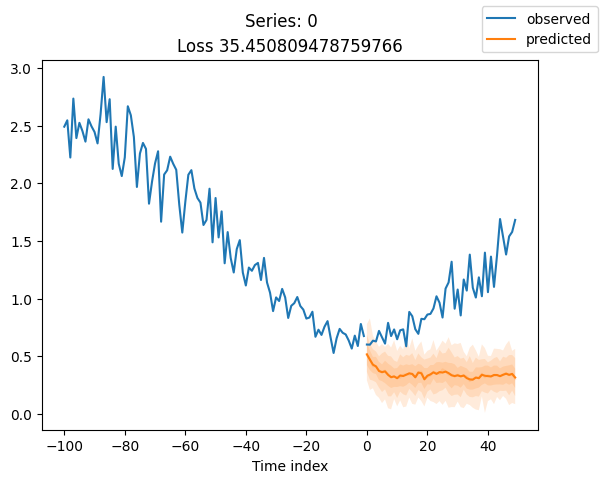

In [677]:
series = validation.x_to_index(raw_predictions.x)["series"]
for idx in range(1):  # plot 10 examples
    best_model.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)
    plt.suptitle(f"Series: {series.iloc[idx]}")

tensor([[ 1.5235,  0.6981, -1.3162,  0.1071],
        [ 1.5235,  0.6974, -1.3297,  0.1060],
        [ 1.5234,  0.6973, -1.3395,  0.1056],
        [ 1.5233,  0.6973, -1.3349,  0.1062],
        [ 1.5232,  0.6973, -1.3342,  0.1064],
        [ 1.5232,  0.6973, -1.2974,  0.1089],
        [ 1.5231,  0.6973, -1.2875,  0.1088],
        [ 1.5230,  0.6973, -1.2993,  0.1076],
        [ 1.5230,  0.6973, -1.2332,  0.1120],
        [ 1.5229,  0.6973, -1.2252,  0.1110],
        [ 1.5228,  0.6973, -1.1939,  0.1124],
        [ 1.5227,  0.6973, -1.2053,  0.1105],
        [ 1.5227,  0.6973, -1.1831,  0.1117],
        [ 1.5226,  0.6973, -1.1613,  0.1123],
        [ 1.5225,  0.6973, -1.2074,  0.1082],
        [ 1.5224,  0.6973, -1.1160,  0.1151],
        [ 1.5224,  0.6973, -1.0492,  0.1178],
        [ 1.5223,  0.6973, -1.0482,  0.1160],
        [ 1.5222,  0.6973, -1.0731,  0.1136],
        [ 1.5221,  0.6973, -1.0371,  0.1163],
        [ 1.5221,  0.6973, -1.0061,  0.1176],
        [ 1.5220,  0.6973, -0.9620

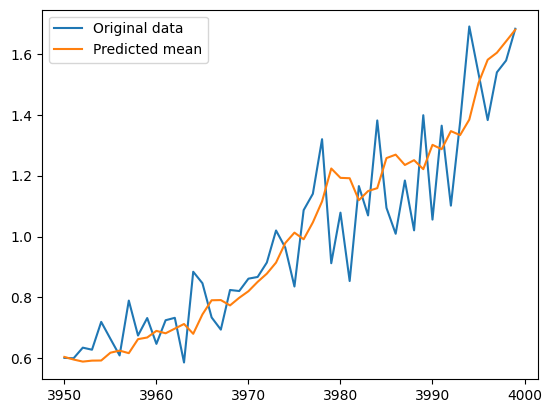

In [ ]:
# Test and plot the model in training mode

for x, y in val_dataloader:
    preds = best_model(x)[0][0]

print(preds)

preds = preds[..., 2] * preds[..., 1] + preds[..., 0]
preds = preds.detach().numpy()

plt.plot(data['time_idx'][-k:], data['value'][-k:], label='Original data')
plt.plot(data['time_idx'][-k:], preds, label='Predicted mean')
plt.legend()
plt.show()